# Introduction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g73kxzbmYlPJT23CiER5sjc-PZgrwpsNM_XXXlOX76GXOTUuYJjFZQ
Mounted at /content/drive


In [2]:
import sklearn.cluster as sc
import gensim
import random
import pandas as pd
import numpy as np
import time
import datetime
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

md = '/content/drive/My Drive/Colab Notebooks/Diplom/'

In [3]:
months = {
    'января':'01',
    'февраля':'02',
    'марта':'03',
    'апреля':'04',
    'мая':'05',
    'июня':'06',
    'июля':'07',
    'августа':'08',
    'сентября':'09',
    'октября':'10',
    'ноября':'11',
    'декабря':'12'
}
months_numbers = list(months.values())

In [4]:
def show_elbow_plot(model,vocab_m):
  scores = []
  for n_cl in tqdm(range(1,10)):
    km = sc.KMeans(init='k-means++',n_clusters=n_cl, random_state=0).fit(model.wv[vocab_m])
    scores+= [-km.score(model.wv[vocab_m])]

  plt.scatter(range(1,10),scores)
  plt.show()

In [5]:
def take_from_model(model):
  vocab_m = np.array(list(model.wv.vocab))
  counts_m = np.array([model.wv.vocab[v].count for v in vocab_m])
  n=10 # Выводит первые n самых частотных слов
  counts_max_m = sorted(np.unique(sorted(counts_m,reverse=True)[:n]),reverse=True)
  freq_index = [j  for i in counts_max_m for j in np.where(counts_m == i)[0]]
  freq_m = [vocab_m[i] for i in freq_index]
  return vocab_m, counts_m, counts_max_m, freq_m

In [6]:
def correct_text_news(text):
    try:
        if text.find('РИА Новости')!=-1:
            text_start = text.find('РИА Новости')+len('РИА Новости')+2
            text = text[text_start:]
    except:
        print(text)
    return text

def convert_to_datetime(date,time):
    d = date.split()
    # d = d[0] + '-' + months[d[1]] +  '-' + d[2]
    d = d[2] + '-' + months[d[1]] +  '-' + d[0]
    # print(d)
    return pd.to_datetime(d + ' '+ time + ':00')

def take_list_from_tags(tags_str):
    s = tags_str[1:-1]
    s = s.replace(' ','_')
    s = s.replace("',_'",' ')
    s = s.replace("'",'')
    s = s.split()
    return s

# Обработка новостей 2020

In [7]:
data = pd.read_pickle(md+'data/news_ria_2020')

In [ ]:
def get_data_with_filename(filename):
  # data = pd.read_csv(file_name).drop('Unnamed: 0',axis=1)
  data = pd.read_pickle(filename)
  data.dropna(subset=['text'], inplace=True)
  data['text'] = [correct_text_news(data.loc[i,'text']) for i in range(len(data))]
  data = data.iloc[np.where(np.array(data.text!=['' for _ in data.text]))[0]]

  # print(len(data))
  data.index = np.arange(len(data))
  data = data.iloc[np.where(np.array(data.text!=['' for _ in data.text]))[0]]
  # print(len(data))

  data['dt'] = [convert_to_datetime(data.date[i], data.time[i]) for i in range(len(data))]
  data['main_text'] = data.headline + '. '+ data.text
  data = data.drop(['date','time', 'link', 'headline', 'text'],axis=1)
  data = data.sort_values('dt',ignore_index=True)
  
  return data

In [ ]:
# for i in tqdm(range(0,len(months_numbers))):
#   d = get_data_with_filename(md+'data/news_'+months_numbers[i]+'_2020')
#   print(d.dt.head(1))
#   print(d.dt.tail(1))

In [ ]:
# datas = [get_data_with_filename(md+'data/news_'+months_numbers[i]+'_2020') for i in range(len(months_numbers))]

data = get_data_with_filename(md+'data/news_'+months_numbers[0]+'_2020') 
for i in tqdm(range(1,len(months_numbers))):
  data = data.append(get_data_with_filename(md+'data/news_'+months_numbers[i]+'_2020'))
  # print(i)
data.index = np.arange(len(data))
data

,views,tags,dt,main_text
0,12388,"[Новый год—2020, Парковка, Москва, Общество]",2020-01-01 00:33:00,Парковка в Москве в новогодние праздники будет...
1,1029790,"[Новый год—2020, Шоу-бизнес, Анастасия Заворот...",2020-01-01 00:38:00,Анастасия Заворотнюк поблагодарила россиян за ...
2,137369,"[Культура, Россия, Шоу-бизнес, Юрий Лоза, Нико...",2020-01-01 00:57:00,Лоза отреагировал на критику концертов Пугачев...
3,24294,"[Угрозы в адрес журналистов Sputnik Эстония, Е...",2020-01-01 01:08:00,Sputnik Эстония перешел на работу в чрезвычайн...
4,88263,"[Ситуация на Украине, Новый год, Владимир Зеле...",2020-01-01 01:19:00,Зеленский в новогоднем поздравлении призвал ук...
...,...,...,...,...
45924,455876,"[Оппозиционная платформа - За жизнь, Ситуация ...",2020-12-31 20:07:00,Депутат Рады надел шапку с красной звездой и о...
45925,29885,"[Домодедово (аэропорт), Шереметьево (аэропорт)...",2020-12-31 21:16:00,В Москве задержали или отменили около 105 рейс...
45926,42263,"[Россия, Снегурочка, Дед Мороз, Сургут, ДТП, П...",2020-12-31 21:42:00,В Сургуте Дед Мороз разбился в ДТП. Мужчина в ...
45927,40433,"[Распространение коронавируса, Панамериканская...",2020-12-31 23:19:00,ВОЗ внесла вакцину Pfizer в список для экстрен...


In [ ]:
data.to_pickle(md+'data/news_2020')

tags = [] 
for _ in  data.tags:
    tags+=take_list_from_tags(_)
ut = np.unique(tags) #1168

tagsu = dict(zip(ut, np.zeros(len(ut)).astype('int64')))
for i in tags:
    tagsu[i]+=1
    
utu = np.array([tagsu[i] for i in ut])

ut[np.where(utu >10)]
utpl = ut[np.where(utu >50)]
utpl
tags = np.array(tags)
tags = tags.reshape(10,-1)
c = np.zeros(len(tags))
for i in range(len(tags)):
    for j in range(len(tags[i])):
        if tags[i][j] in utpl[-1]:
            c[i]+=1
            
plt.plot(c)
plt.show()

t = data.groupby(pd.Grouper(key="dt", freq="1D"))['tags'].apply(list)
tt = [[] for _ in range(len(t))]
for i in range(len(tt)):
    for j in range(len(t[i])):
        tt[i]+=take_list_from_tags(t[i][j])
        
tt
c = np.zeros(len(tt))
for i in range(len(tt)):
    for j in range(len(tt[i])):
        if tt[i][j] in utpl[-1]:
            c[i]+=1
            
plt.plot(c)
plt.show()

# **создание моделей w2v d2v ft**

In [8]:
import string
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import RussianStemmer 
rs = RussianStemmer()

In [9]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package brown to /root/nltk_data...
       |   Unzipping corpora/brown.zip.
       | Downloading package brown_tei to /root/nltk_data...
       |   Unzipping corpora/brown_tei.zip.
       | Downloading package cess_cat to /root/nltk_data...
       |   Unzipping corpora/cess_cat.zip.
       | Downloading package cess_esp to /root/nltk_data...
       |   Unzipping corpora/cess_esp.zip.
       | Downloa

True

In [17]:
stop_words = stopwords.words('russian')
stop_words.extend(['что','однако', 
                   'это', 'так', 'вот', 'быть','уже', 'как', 'в','из-за', '—', '–', 'к', 'на', '...','»', '«','``',"''"])
stop_words.extend(list(string.punctuation))

def digit_flag(word):
      if word.isdigit():
          word = 'число'
      return word

def tokenize_sent2words_ru(sentence):
    sentence=sentence.lower()
    tokens = word_tokenize(sentence, 'russian')
    tokens = [rs.stem(i) for i in tokens if (i not in stop_words)]
    tokens = [digit_flag(_) for _ in tokens]
    return tokens


def tokenize_text2words_ru(text):
#     res = []
#     for sent in sent_tokenize(text, 'russian'):
#         res+= tokenize_sent2words_ru(sent)
# #     res = [tokenize_sent2words_ru(sent) for sent in sent_tokenize(text, 'russian')]
    return [tokenize_sent2words_ru(sent) for sent in sent_tokenize(news[2], 'russian')]

In [18]:
# tokenize_text2words_ru(data['main_text'][0])

In [ ]:
data_train = [tokenize_text2words_ru(main_text) for main_text in tqdm(data['main_text'])]

In [ ]:
w2v = gensim.models.Word2Vec(tqdm(data_train), workers=8, iter=20,)
w2v.save(md+'models/w2v.model')

data_train_doc=[]
for main_text in tqdm(data['main_text']):
    w = tokenize_text2words_ru(main_text)
    s = ''
    for _ in w:
        s+=_+' '
    data_train_doc+=[s]
data_train_doc[0]

In [ ]:
tagged_data = [gensim.models.doc2vec.TaggedDocument(_d, [i]) for i, _d in enumerate(data_train)]

In [ ]:
d2v = gensim.models.Doc2Vec(documents = tagged_data, workers=8)
d2v.save(md+'models/d2v.model')

SyntaxError: ignored

In [ ]:
ft = gensim.models.FastText(sentences=data_train,workers=8, iter = 20)
ft.save(md+'models/ft.model')

# **загрузка w2v модели**

In [22]:
w2v = gensim.models.Word2Vec.load(md+"models/w2v.model")

In [23]:
def get_w2v_similar_words(pos = "", neg = ""):
    pos = [rs.stem(i) for i in pos.split()]
    neg = [rs.stem(i) for i in neg.split()]
    return w2v.wv.most_similar(positive=pos, negative = neg)

get_w2v_similar_words('путин', '')

[('президент', 0.9330856204032898),
 ('пресс-конференц', 0.9044589996337891),
 ('владимир', 0.8743478655815125),
 ('лидер', 0.8300076723098755),
 ('поздрав', 0.8014653921127319),
 ('жириновск', 0.8009012937545776),
 ('поздравлен', 0.8003649711608887),
 ('выраз', 0.7971187829971313),
 ('надежд', 0.7965977191925049),
 ('баллотирова', 0.7962509393692017)]

In [ ]:
pu = w2v.wv['крым']
pr = w2v.wv['владимир']

In [ ]:
w2v.wv.similarity('путин','россия')

0.98577994

In [ ]:
vocab_w, counts_w, counts_max_w, freq_w = take_from_model(w2v)

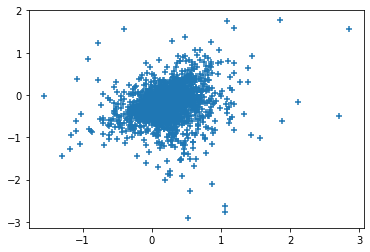

In [ ]:
j=0
www = np.array([w2v.wv[vocab_w[i]][j:j+2] for i in range(len(vocab_w))])
plt.scatter(www.T[0],www.T[1], marker='+')
plt.show()

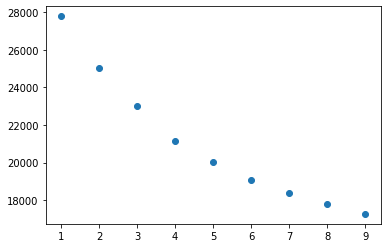

In [ ]:
show_elbow_plot(w2v,vocab_w)

# **загрузка d2v модели**


In [24]:
d2v = gensim.models.Doc2Vec.load(md+"models/d2v.model")

In [25]:
def get_d2v_similar_words(pos = "", neg = ""):
    pos = [rs.stem(i) for i in pos.split()]
    neg = [rs.stem(i) for i in neg.split()]
    return d2v.wv.most_similar(positive=pos, negative = neg)

get_d2v_similar_words('путин', '')

[('президент', 0.9996201992034912),
 ('владимир', 0.9989527463912964),
 ('зеленск', 0.9976798295974731),
 ('украин', 0.9970702528953552),
 ('поздравлен', 0.9967381954193115),
 ('песк', 0.9965589046478271),
 ('кулеб', 0.996475100517273),
 ('дмитр', 0.9959415197372437),
 ('глав', 0.9959041476249695),
 ('крым', 0.9957326054573059)]

In [26]:
d2v.wv.similarity(['путин','россия'], 'крым')

array([0.8074896, 0.5835799], dtype=float32)

In [27]:
d2v.infer_vector(['путин', 'крым'])

array([ 0.00206616, -0.00371266, -0.00492413,  0.00319149,  0.00723905,
       -0.00934673,  0.00941746, -0.0030179 ,  0.00805557, -0.00247744,
        0.00153176,  0.00051769, -0.00483779,  0.00065148, -0.00723182,
        0.00490784, -0.00177463, -0.00266364, -0.00620787, -0.00541411,
        0.00456686,  0.00833002,  0.00080364,  0.01350697,  0.0004526 ,
       -0.00162867, -0.00797527, -0.0134929 , -0.00096979, -0.00724931,
       -0.01182171,  0.00573189,  0.0057509 ,  0.00931716, -0.00511959,
        0.00843105, -0.0103374 ,  0.00546037,  0.00533021, -0.00218906,
        0.00839348,  0.00226956,  0.00779909,  0.00467114, -0.00824966,
        0.00357767, -0.01563852,  0.00375859,  0.00179241, -0.0030798 ,
       -0.00447687,  0.00703489, -0.00633069, -0.01008649, -0.00021835,
        0.00199405, -0.00099337,  0.00248176, -0.00497887, -0.00202607,
        0.00768849, -0.01762893,  0.01206967, -0.00675314, -0.00024016,
       -0.00071989,  0.00910934, -0.00414459, -0.00242292,  0.00

In [ ]:
np.linalg.norm(d2v.infer_vector(['путин', 'крым']))

0.058298767

In [ ]:
vocab_d, counts_d, counts_max_d, freq_d = take_from_model(d2v)

In [ ]:
d2v.docvecs.count

770

In [ ]:
import sklearn.cluster as sc
n_clstr = 10

In [ ]:
kmeans = sc.KMeans(init='k-means++',n_clusters=n_clstr , random_state=0,n_jobs = 8).fit(d2v.wv[vocab_d])
cc_X = kmeans.cluster_centers_
len(cc_X)

10

In [ ]:
freq_kmeans = [np.where(kmeans.labels_==i)[0].shape[0] for i in range(len(cc_X))]
freq_kmeans

[234, 1166, 128, 475, 155, 1411, 8, 222, 709, 356]

In [ ]:
mgn = []
cw = []

for i in range(len(cc_X)):

  magn = []
  closest_word_now = []
  for v in vocab_d[kmeans.labels_==i]:
    vec = d2v.wv[v]
    magn_now = np.linalg.norm(vec-cc_X[i])
    closest_word_now+=[v]
    magn+=[magn_now]
    # if magn>magn_now:
    #   closest_word_now = v
    #   magn = magn_now

  mgn+=[magn]
  cw+=[closest_word_now]


In [ ]:
[(np.min(mgn[i]), np.max(mgn[i])) for i in range(len(mgn))]

[(0.031294703, 0.2712331),
 (0.026189005, 0.1727128),
 (0.05998051, 2.0133183),
 (0.029973319, 0.24030335),
 (0.04068097, 1.5790569),
 (0.026477622, 0.4513114),
 (0.9391384, 2.1760485),
 (0.03765154, 1.7204899),
 (0.029066438, 0.1950517),
 (0.03000032, 0.36657444)]

In [ ]:
# cw[0]

In [ ]:
np.max(mgn[6])

2.1760485

In [ ]:
n=6
vec = d2v.wv[cw[n][np.argmax(mgn[n])]]
np.linalg.norm(vec-cc_X[n])

2.1760485

In [ ]:
d2v.wv.vocab['стопкоронавирус.рф'].count

104

In [ ]:
cw[n][np.argmax(mgn[n])]

'стопкоронавирус.рф'

In [ ]:
np.linalg.norm(d2v.wv['стопкоронавирус.рф'])

3.4835043

In [ ]:
d2v.wv['стопкоронавирус.рф']

array([ 0.18057394, -0.17916223, -0.01004103,  0.49509838,  0.14333956,
       -0.38316274, -0.41618267, -0.21068478,  0.3486654 ,  0.00608553,
        0.17113647, -0.04996122, -0.43980935,  0.2509863 ,  0.24437213,
        0.33260888, -0.31708962, -0.58822745,  0.16536056, -0.12480274,
        0.69380635,  0.5489272 ,  0.02213292,  0.7149545 ,  0.13621506,
       -0.26568878,  0.30170318, -0.4472095 , -0.22288883,  0.3691268 ,
       -0.6512158 ,  0.3424208 ,  0.3586781 ,  0.45625928, -0.34566346,
        0.276637  , -0.19769141,  0.5393516 , -0.44732347, -0.04862861,
        0.40810293,  0.10694569,  0.03606271,  0.09981769,  0.19000532,
       -0.0467746 , -0.5542984 , -0.16746256,  0.17216057, -0.34053612,
       -0.5465533 ,  0.14119633,  0.67453426, -0.66048414, -0.17799881,
        0.57164735,  0.35865095, -0.20824328,  0.26705456,  0.30643472,
        0.16787995, -0.6528819 ,  0.45906955, -0.29536512, -0.2333105 ,
       -0.19432516, -0.08314178,  0.04889167, -0.40970752,  0.22

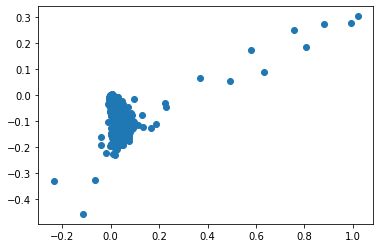

In [ ]:
j=0
ddd = np.array([[d2v.wv[vocab_d[i]][94],d2v.wv[vocab_d[i]][10]] for i in range(len(vocab_d))])
plt.scatter(ddd.T[0],ddd.T[1])
plt.show()

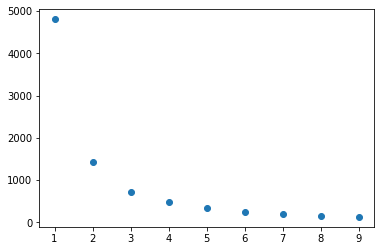

In [ ]:
show_elbow_plot(d2v,vocab_d)

# **загрузка ft**

In [30]:
ft = gensim.models.FastText.load(md+"models/ft.model")

In [31]:
ft.wv.most_similar('стопкоронавирус.рф')

[('коронавирусн', 0.9010807275772095),
 ('эльвир', 0.8822565078735352),
 ('ухудш', 0.8649866580963135),
 ('худш', 0.8610246181488037),
 ('коронавирус', 0.8602175712585449),
 ('вирусолог', 0.8476646542549133),
 ('надзорн', 0.8469855189323425),
 ('хопкинс', 0.8457717895507812),
 ('вирусн', 0.8456740379333496),
 ('смертоносн', 0.8442677855491638)]

In [ ]:
vocab_f, counts_f, counts_max_f, freq_f = take_from_model(ft)

In [ ]:
freq_f

['число',
 'год',
 'росс',
 'котор',
 'российск',
 'такж',
 'нов',
 'стран',
 'сво',
 'слов']

In [ ]:
vocab_f = np.array(list(ft.wv.vocab))

In [ ]:
counts_f = np.array([ft.wv.vocab[v].count for v in vocab_f])

In [ ]:
n=10 # Выводит первые n самых частотных слов
counts_max_f = sorted(np.unique(sorted(counts_f,reverse=True)[:n]),reverse=True)
freq_index = [j  for i in counts_max_f for j in np.where(counts_f == i)[0]]
freq_f = [vocab_f[i] for i in freq_index]
freq_f

['число',
 'год',
 'росс',
 'котор',
 'российск',
 'такж',
 'нов',
 'стран',
 'сво',
 'слов']

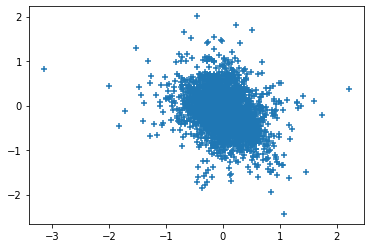

In [ ]:
j=0
fff = np.array([ft.wv[vocab_f[i]][j:j+2] for i in range(len(vocab_f))])
plt.scatter(fff.T[0],fff.T[1], marker='+')
plt.show()

In [ ]:
fff.min()

-1.3520439

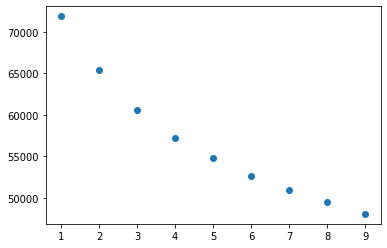

In [ ]:
show_elbow_plot(ft,vocab_f)

# Обработка тегов

In [ ]:
data = pd.read_pickle(md+'data/news_ria_2020')

In [ ]:
# def parse_lenta(input_file, output_file, use_preprocess=True):
parts = {
    "society": 0.02,
    "economy": 0.02,
    "sports": 0.02,
    "technology": 0.02,
    "science": 0.02,
    "other": 0.02,
    "entertainment": 0.02
}
topics_mapping = {
    "Экономика": "economy",
    "Спорт": "sports",
    "Силовые структуры": "society",
    "Бизнес": "economy",
    "Культпросвет": "entertainment",
    ("Наука и техника", "Игры"): "entertainment",
    ("Наука и техника", "Наука"): "science",
    ("Наука и техника", "Космос"): "science",
    ("Наука и техника", "Жизнь"): "science",
    ("Наука и техника", "История"): "science",
    ("Наука и техника", "Оружие"): "society",
    ("Наука и техника", "Гаджеты"): "technology",
    ("Наука и техника", "Софт"): "technology",
    ("Наука и техника", "Техника"): "technology",
    ("Мир", "Общество"): "society",
    ("Мир", "Политика"): "society",
    ("Мир", "Происшествия"): "society",
    ("Мир", "Конфликты"): "society",
    ("Мир", "Преступность"): "society",
    ("Россия", "Политика"): "society",
    ("Россия", "Общество"): "society",
    ("Россия", "Происшествия"): "society",
    ("Интернет и СМИ", "Мемы"): "technology",
    ("Интернет и СМИ", "Киберпреступность"): "technology",
    ("Интернет и СМИ", "Интернет"): "technology",
    ("Интернет и СМИ", "Вирусные ролики"): "technology",
    ("Ценности", "Стиль"): "other",
    ("Ценности", "Явления"): "other",
    ("Ценности", "Внешний вид"): "other",
    ("Ценности", "Движение"): "technology",
    ("Из жизни", "Происшествия"): "society",
    ("Путешествия", "Происшествия"): "society",
}

In [10]:
tags = [] 
for _ in  data.tags:
    tags+=[_]

tags = np.array(tags)
all_tags = [j for t in tags for j in t]
uniq_tags = np.unique(all_tags) #1183
len(uniq_tags)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


12273

In [11]:
tagsu = dict(zip(uniq_tags, np.zeros(len(uniq_tags)).astype('int64')))
for i in all_tags:
    tagsu[i]+=1
    
utu = np.array([tagsu[i] for i in uniq_tags])# utu - частота тегов uniq_tags
uniq_tags[np.where(utu >3000)]

array(['В мире', 'Здоровье - Общество', 'Коронавирус COVID-19',
       'Коронавирус в России', 'Москва', 'Общество', 'Происшествия',
       'Распространение коронавируса', 'Россия', 'США'], dtype='<U178')

In [12]:
main_tags = set(['В мире', 'Политика', 'Происшествия', 
                 'Общество', 'Экономика', 'Наука',
                 'Вокруг спорта', 'Культура']) # ,'Коронавирус COVID-19', 'Туризм'

In [13]:
m_t_joint = np.where(np.array([not main_tags.isdisjoint(tag) for tag in tags])==True)[0]
m_t_joint.shape

(36457,)

In [14]:
main_tags_list = sorted(list(main_tags))

mt_indexer =  dict(zip(main_tags_list, range(len(main_tags_list))))
sport_index = mt_indexer['Вокруг спорта']
sport_tags = ['UFC','Футбол','Хоккей',
              'Хабиб Нурмагомедов','Фигурное катание','Российская премьер-лига',
              'Биатлон','Единоборства','Зенит']
for st in sport_tags:
  mt_indexer[st] = sport_index

mt_indexer_keys = list(mt_indexer.keys())

main_tags_dict = dict(zip(main_tags_list,np.zeros(len(main_tags_list))))

main_tags_dict_reverse = dict(zip(range(len(main_tags_list)), main_tags_list))

main_tags_id_in_data = [-1 for _ in range(len(tags))]

clear_tags_index = []
clear_tags_value = []
external_counter = 0 # счетчик пересекающихся тегов
for t_i, t in enumerate(tags):
  # counter=0
  # now_tag=-1
  # for mtl_i, mtl in enumerate(main_tags_list):
  #   if mtl in t:
  #     main_tags_dict[mtl]+=1
  #     counter+=1
  #     now_tag = mtl_i
  # if counter>1:
  #   external_counter+=1
  # elif counter==1:
  #   clear_tags_index.extend([t_i])
  #   clear_tags_value.extend([now_tag])

  asd = 0
  now_tag = -1
  for mtik in mt_indexer_keys:
    if mtik in t:
      if now_tag ==-1:
        now_tag = mt_indexer[mtik]
      elif  mt_indexer[mtik]!=now_tag:
        now_tag=-1
        external_counter+=1
        break
  main_tags_id_in_data[t_i] = now_tag

  if now_tag!=-1:
    main_tags_dict[main_tags_dict_reverse[now_tag]]+=1
    clear_tags_index.extend([t_i])
    clear_tags_value.extend([now_tag])

main_tags_id_in_data = np.array(main_tags_id_in_data)
data['main_tag'] = main_tags_id_in_data

print(external_counter)
main_tags_dict

1354


{'В мире': 13518.0,
 'Вокруг спорта': 2885.0,
 'Культура': 1445.0,
 'Наука': 1077.0,
 'Общество': 9920.0,
 'Политика': 981.0,
 'Происшествия': 5178.0,
 'Экономика': 2527.0}

In [15]:
qwe = main_tags_id_in_data>0
qwe.sum()

24013

In [16]:
len(clear_tags_index)==len(clear_tags_value), len(clear_tags_index)

(True, 37531)

<BarContainer object of 8 artists>

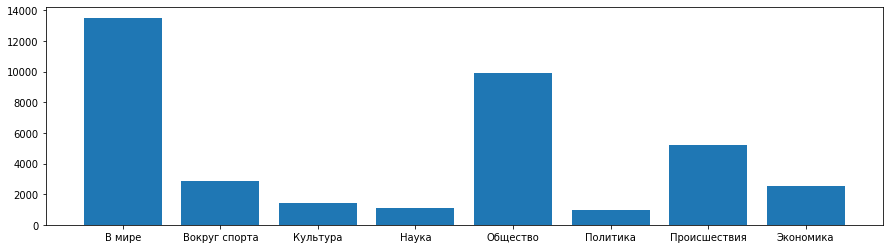

In [ ]:
keys = main_tags_dict.keys()
values = main_tags_dict.values()

plt.figure(figsize=(15, 4))
plt.bar(keys, values)

In [ ]:
np.sum(list(main_tags_dict.values())), len(tags[m_t_joint])

(37531.0, 36457)

In [ ]:
m_t = np.array([main_tags.isdisjoint(tag) for tag in tags])
non_normal_tags = tags[np.where(m_t==True)] # теги, не входящие в main_tags
all_non_normal_tags=[]
for nnt in non_normal_tags:
  all_non_normal_tags += nnt
all_non_normal_tags_un = np.unique(all_non_normal_tags)
len(non_normal_tags)

9472

In [ ]:
nntu = dict(zip(all_non_normal_tags_un, np.zeros(len(all_non_normal_tags_un)).astype('int64')))
for i in all_non_normal_tags:
    nntu[i]+=1

nntu_keys = np.array(list(nntu.keys()))
nntu_vals = np.array(list(nntu.values()))
# utu = np.array([tagsu[i] for i in uniq_tags])# utu - частота тегов uniq_tags
nntu_keys[np.where(nntu_vals > 100)]

array(['UFC', 'Авторы', 'Александра Трусова', 'Безопасность',
       'Белоруссия', 'Биатлон', 'ВОЗ', 'Великобритания', 'Владимир Путин',
       'Германия', 'Госдума РФ', 'Дональд Трамп', 'Евгений Плющенко',
       'Единоборства', 'Жилье', 'ЗОЖ', 'Здоровье', 'Здоровье - Общество',
       'Зенит', 'Знаменитости', 'Италия', 'Китай', 'Коронавирус COVID-19',
       'Коронавирус в России', 'Коронавирусы', 'Космос - РИА Наука',
       'Международная космическая станция (МКС)', 'Мнение - Авторы',
       'Москва', 'Московская область (Подмосковье)',
       'Новое оружие России', 'Новости - Туризм', 'Открытия - РИА Наука',
       'Питание', 'Распространение коронавируса',
       'Религия и мировоззрение', 'Республика Крым', 'Роскосмос',
       'Российская премьер-лига', 'Россия', 'США', 'Сергей Собянин',
       'Смешанные боевые искусства (ММА)', 'Сочи', 'Спорт', 'Технологии',
       'Туризм', 'Турция', 'Украина', 'ФК Спартак (Москва)',
       'Федеральная служба по надзору в сфере защиты прав п

In [ ]:
main_tags_dict

{'В мире': 13518.0,
 'Вокруг спорта': 2885.0,
 'Культура': 1445.0,
 'Наука': 1077.0,
 'Общество': 9920.0,
 'Политика': 981.0,
 'Происшествия': 5178.0,
 'Экономика': 2527.0}

In [ ]:
annt_count = np.array([tagsu[_] for _ in all_non_normal_tags_un])
all_non_normal_tags_un[np.where(annt_count >1000)]

array(['Азербайджан', 'Александр Лукашенко', 'Армения', 'Белоруссия',
       'ВОЗ', 'Владимир Путин', 'Германия', 'Госдума РФ', 'Дональд Трамп',
       'Здоровье', 'Здоровье - Общество', 'Китай', 'Коронавирус COVID-19',
       'Коронавирус в России', 'Коронавирусы', 'Москва',
       'Распространение коронавируса', 'Россия', 'США',
       'Ситуация в Нагорном Карабахе',
       'Следственный комитет России (СК РФ)', 'Туризм', 'Украина',
       'Федеральная служба по надзору в сфере защиты прав потребителей и благополучия человека (Роспотребнадзор)',
       'Футбол', 'Шоу-бизнес'], dtype='<U125')

# обучение распознаванию тегов

In [ ]:
w2v_tags = gensim.models.Word2Vec.load(md+'models/w2v_tags_2020.model')

In [ ]:
import string
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import RussianStemmer 
rs = RussianStemmer()

In [ ]:
import nltk
nltk.download()

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что','однако', 
                   'это', 'так', 'вот', 'быть','уже', 'как', 'в','из-за', '—', '–', 'к', 'на', '...','»', '«','``',"''"])
stop_words.extend(list(string.punctuation))

def tokenize_sent2words_ru(sentence):
    sentence=sentence.lower()
    tokens = word_tokenize(sentence, 'russian')
    tokens = [rs.stem(i) for i in tokens if (i not in stop_words)]
    for i in range(len(tokens)): 
        if tokens[i].isdigit():
            tokens[i] = 'число'
    return tokens


def tokenize_text2words_ru(text):
    res = []
    for sent in sent_tokenize(text, 'russian'):
        res+= tokenize_sent2words_ru(sent)
#     res = [tokenize_sent2words_ru(sent) for sent in sent_tokenize(text, 'russian')]
    return res

In [ ]:
# tokenize_text2words_ru(data['main_text'][0])+tags[0]

In [ ]:
data_train_for_tags = [tokenize_text2words_ru(main_text)+tags[i] for i, main_text in tqdm(enumerate(data['main_text']))]

In [ ]:
w2v_tags = gensim.models.Word2Vec(tqdm(data_train_for_tags), workers=8, iter=20, min_count=10)
w2v_tags.save(md+'data/w2v_tags_2020.model')

In [ ]:
w2v_tags.similarity(main_tags_list[0], main_tags_list[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


1.0

In [ ]:
nnt_change=[]
for nnt in non_normal_tags:
  vars = dict(zip(main_tags_list, np.zeros(len(main_tags_list))))
  for t in nnt:
    for mtl in main_tags_list:
      try:
        now_sim = w2v_tags.similarity(t, mtl)
        # vars[mtl]=max(vars[mtl],now_sim)
        vars[mtl]+=now_sim
        # if now_sim==1:
        #   vars[mtl]+=10
      except:
        # print(t+' '+ mtl +' не в словаре w2v')
        qwe=1
  nnt_change+=[[main_tags_list[np.argmax(list(vars.values()))], nnt ]]
# nnt_change[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


In [ ]:
nnt_change[10:20]

In [ ]:
for i in main_tags_list:
  print('* '+i)# , end='___: '
  print([_ for _ in w2v_tags.most_similar(i)])
  

* В мире
[('Протесты', 0.6304927468299866), ('Бритни Спирс', 0.6057103872299194), ('Стамбул', 0.595970630645752), ('Евросовет', 0.5915004014968872), ('Баден-Вюртемберг', 0.5864671468734741), ('Видео', 0.5855875611305237), ('Северная Америка', 0.5839543342590332), ('Токио', 0.5822155475616455), ('Центральное разведывательное управление', 0.5818876028060913), ('Бразилия', 0.5816608667373657)]
* Вокруг спорта
[('Легкая атлетика', 0.8596296906471252), ('Художественная гимнастика', 0.8319743275642395), ('Спорт в условиях пандемии коронавируса', 0.828439474105835), ('Плавание', 0.8175042867660522), ('Дмитрий Губерниев', 0.8115640878677368), ('Теннис', 0.8030461668968201), ('Борьба', 0.8008598685264587), ('Олимпийские игры', 0.7972670197486877), ('Материалы РИА Спорт', 0.7943527102470398), ('Sport Stories', 0.7929099202156067)]
* Культура
[('Шоубиз', 0.7915530800819397), ('Шоу-бизнес', 0.7580008506774902), ('Новости культуры', 0.7524923086166382), ('Музыка', 0.7449674606323242), ('Александр Г

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


# Графики популярных тегов

In [ ]:
grdata = data.groupby(pd.Grouper(key="dt", freq="3D")).agg({'views':['sum','min','max','mean']})
# grdata

In [ ]:
# np.array(data['views']==None).sum()

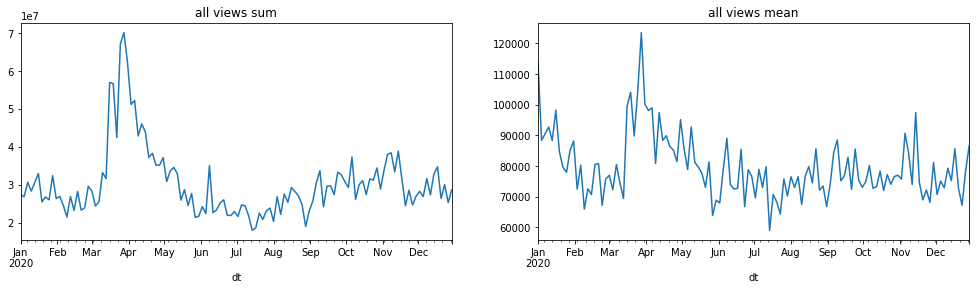

In [ ]:
plt.figure(figsize=(17, 4))
plt.subplot(1, 2, 1)
plt.title('all views sum')
grdata['views']['sum'].plot()
plt.subplot(1, 2, 2)
plt.title('all views mean')
grdata['views']['mean'].plot()

# Графики разных тегов

In [ ]:
def draw_plot_with_polyfit(now_grtd):
  x = np.arange(len(now_grtd))

  polif = np.polyfit(x, now_grtd.to_numpy(), 20) # grtd['views']['mean'].index
  f = np.poly1d(polif)

  y = f(x)
  # plt.figure(figsize=(15, 4))
  # plt.subplot(2, 1, 1)
  plt.plot(now_grtd.index,y)
  # plt.subplot(2, 1, 2)
  plt.plot(now_grtd)

Вокруг спорта


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RankWarning: Polyfit may be poorly conditioned
  app.launch_new_instance()


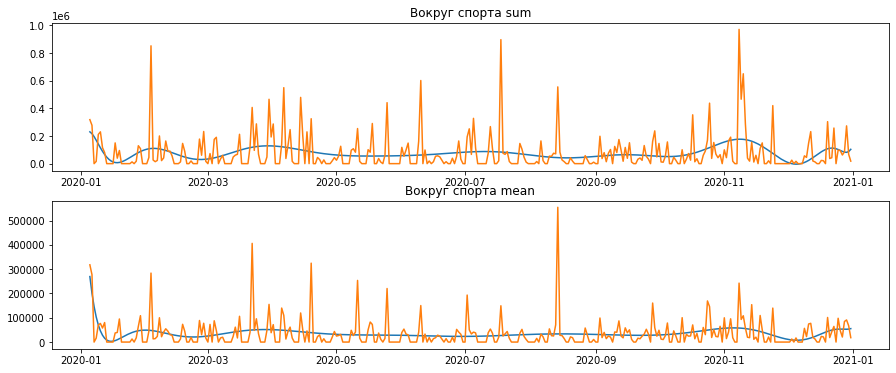

In [ ]:
now_tag_on_plot = main_tags_list[1]
print(now_tag_on_plot)
td = data.iloc[np.where([now_tag_on_plot in t for t in tags])[0]]
grtd = td.groupby(pd.Grouper(key="dt", freq="D")).agg({'views':['sum','min','max','mean']})
grtd = grtd.fillna(0)
# grtd['views']['sum'] = np.nan_to_num(grtd['views']['sum'])
# grtd['views']['mean'] = np.nan_to_num(grtd['views']['mean'])

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.title(f'{now_tag_on_plot} sum')
draw_plot_with_polyfit(grtd['views']['sum'])
# plt.plot(grtd['views']['sum'])
plt.subplot(2, 1, 2)
plt.title(f'{now_tag_on_plot} mean')
draw_plot_with_polyfit(grtd['views']['mean'])
# plt.plot(grtd['views']['mean'])
# grtd['views']['sum'].plot()

# Классификаторы - предобработка

In [ ]:
import string
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import RussianStemmer 
rs = RussianStemmer()

In [ ]:
import nltk
nltk.download()

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что','однако', 
                   'это', 'так', 'вот', 'быть','уже', 'как', 'в','из-за', '—', '–', 'к', 'на', '...','»', '«','``',"''",'.',','])
stop_words.extend(list(string.punctuation))

def digit_flag(word):
      if word.isdigit():
          word = 'число'
      return word

def tokenize_sent2words_ru(sentence):
    sentence=sentence.lower()
    tokens = word_tokenize(sentence, 'russian')
    tokens = [rs.stem(i) for i in tokens]#  if (i not in stop_words)
    tokens = [digit_flag(_) for _ in tokens]
    return tokens

def tokenize_new2item_ru(news):
    res = {}
    res["label"] = news[1]
    tokens = word_tokenize(news[0], 'russian')
    tokens = [rs.stem(i) for i in tokens if (i not in stop_words)]
    tokens = [digit_flag(_) for _ in tokens]
    text = ''
    for token in tokens:
      text+=token+' '
    # res["text"] = [tokenize_sent2words_ru(sent) for sent in sent_tokenize(news[0], 'russian')]
    res["text"] = text 
    return res

In [ ]:
data_balanced = data[data.main_tag>-1]
# data_balanced['main_tag'] = clear_tags_value
data_balanced.index = np.arange(len(data_balanced))
data_balanced = data_balanced.to_numpy()[:,[3,4]]
# data_balanced[:10]
# data_balanced[['tags', 'main_tag']]

In [ ]:
data_bal_pred = [tokenize_new2item_ru(news) for news in tqdm(data_balanced)]
len(data_bal_pred)

37531

In [ ]:
df = pd.DataFrame.from_dict(data_bal_pred)
df.to_pickle(md+'data/data_bal_pred_with_stopwords')

# **классификаторы и thidf**

In [ ]:
def load_data_texts(path):
  df  = pd.read_pickle(md + path)
  df = df.to_numpy()
  return [{"label": d[0],"text": d[1], } for d in df]

In [ ]:
data_bal_pred = load_data_texts('data/data_bal_pred_with_stopwords')

In [ ]:
data_bal_pred[:3]

[{'label': 4,
  'text': 'парковк москв новогодн праздник бесплатн парковк москв новогодн праздник бесплатн плоскостн парковк шлагбаум будут работа действ тариф сообща сайт администратор московск парковочн пространств в новогодн праздник число число январ парковк столичн улиц бесплатн остав автомобил оплат числ улиц котор действ тариф число рубл час… отмет плоскостн парковк шлагбаум новогодн праздник будут работа действ тариф говор сообщен так новогодн гулян столиц пройдут различн площадк ожида больш числ люд поэт автомобилист прос внимательн оставля машин разрешен мест создава помех дорог меша горожан добира мест мероприят '},
 {'label': 4,
  'text': 'анастас заворотнюк поблагодар россия поддержк актрис анастас заворотнюк канун нов год поблагодар поддержива мол всем наст переда огромн привет благодар поддержк ваш молитв душевн тепл котор дар отмеча сообщен инстаграм артистк автор публикац такж переда пожелан здоров благополуч заворотнюк сем пуст след год станет счастлив пуст исполн ваш

In [ ]:
def balancing_classes_data(X, more_less = True, koeff_len = 0.5):
  tags = [news["label"] for news in X]
  un = np.unique(tags)
  un_tags_dict = dict(zip(un, np.zeros(len(un))))
  for i in X:
    un_tags_dict[i["label"]]+=1

  if more_less:
    normal_un_len = 0
    for u in un:
      if un_tags_dict[u]>normal_un_len:
        normal_un_len = un_tags_dict[u]
  else:
    normal_un_len =  un_tags_dict[un[0]]
    for u in un:
      if un_tags_dict[u]<normal_un_len:
        normal_un_len = un_tags_dict[u]

  
  new_dtr=[]

  if more_less:
    normal_un_len = normal_un_len * koeff_len
    for i in X:
      new_dtr+=[i]
      if un_tags_dict[i["label"]]<normal_un_len:
        for _ in range(int(normal_un_len//un_tags_dict[i["label"]])):
          new_dtr+=[i]

  else:
    normal_un_len = normal_un_len / koeff_len
    un_tags_count_less = dict(zip(un, np.zeros(len(un))))
    for i in X:
      if un_tags_count_less[i["label"]]<normal_un_len:
        un_tags_count_less[i["label"]]+=1
        new_dtr+=[i]
  print(normal_un_len)
  return new_dtr

data_bal_pred_balancing = balancing_classes_data(data_bal_pred, False, 0.5)
len(data_bal_pred_balancing)

1962.0


13313

In [ ]:
def data_tr_ts_shaffle(data, koeff = 0.3):
  random.seed(0)
  random.shuffle(data)
  data_tr=[]
  data_ts=[]

  tags = [news["label"] for news in data]
  mtv = np.zeros(len(main_tags_list))
  for d in data:
    mtv[d['label']]+=1
  # mtv = list(main_tags_dict.values())
  mtv_ts = np.zeros(len(mtv))
  for d in data:
    now_tag = d['label']
    if mtv_ts[now_tag] < koeff * mtv[now_tag]:
      data_ts.extend([d])
    else:
      data_tr.extend([d])

    mtv_ts[now_tag]+=1
  return data_tr, data_ts

data_train, data_test = data_tr_ts_shaffle(data_bal_pred_balancing, 0.2) 
len(data_train), len(data_test) 

(10646, 2667)

In [ ]:
X_train_idf_text = [d['text'] for d in data_train]
X_test_idf_text = [d['text'] for d in data_test]

y_train = [d['label'] for d in data_train]
y_test = [d['label'] for d in data_test]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score as cvs
from sklearn import metrics

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 5)#, max_features = 10000
%time X_train_idf = tfidf.fit_transform(X_train_idf_text)
X_test_idf = tfidf.transform(X_test_idf_text)
X_test_idf.shape

CPU times: user 11.8 s, sys: 182 ms, total: 11.9 s
Wall time: 12 s


(2667, 62170)

In [ ]:
clf = LinearSVC(C = 0.6, random_state = 42)
%time clf.fit(X_train_idf, y_train)
print(clf.score(X_test_idf, y_test))
print(clf.score(X_train_idf, y_train))

CPU times: user 1.25 s, sys: 2.4 ms, total: 1.25 s
Wall time: 1.27 s
0.9126359205099362
0.9944580123990231


In [ ]:
clf = LogisticRegression(n_jobs=-1, random_state=42)#,class_weight='balanced'
%time clf.fit(X_train_idf, y_train)
print(clf.score(X_test_idf, y_test))
print(clf.score(X_train_idf, y_train))

CPU times: user 37.3 ms, sys: 74.1 ms, total: 111 ms
Wall time: 16.5 s
0.8995125609298837
0.9570730790907384


In [ ]:
%time cvs_res = cvs(clf, X_train_idf, y_train, cv = 5,n_jobs=8)
print(cvs_res.mean())
print(cvs_res)

CPU times: user 223 ms, sys: 100 ms, total: 324 ms
Wall time: 5.9 s
0.9016530055548573
[0.90375587 0.90183185 0.90418037 0.89995303 0.89854392]


In [ ]:
print(str(clf)[:20])
a = np.array(main_tags_list)
b = metrics.confusion_matrix(y_test,clf.predict(X_test_idf))
pd.DataFrame(data=b,index = a,columns=a)

LinearSVC(C=0.6, cla


,В мире,Вокруг спорта,Культура,Наука,Общество,Политика,Происшествия,Экономика
В мире,349,1,1,4,11,5,15,7
Вокруг спорта,0,390,1,0,1,0,1,0
Культура,2,1,283,0,3,0,0,0
Наука,1,0,1,206,6,0,0,2
Общество,12,1,7,5,323,13,20,12
Политика,19,0,1,0,8,160,1,8
Происшествия,2,1,4,0,21,1,360,4
Экономика,4,0,0,3,20,2,1,363


In [ ]:

predicted_lr = clf.predict(X_test_idf)
# predicted_lr_pr = clf.predict_proba(X_test_idf)
# maxes = np.max(predicted_lr_pr, axis=1)
# predicted_lr = np.where(maxes>0.45, predicted_lr, np.ones(len(predicted_lr))*10)
print(metrics.classification_report(predicted_lr, y_test))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       389
           1       0.99      0.99      0.99       394
           2       0.98      0.95      0.96       298
           3       0.95      0.94      0.95       218
           4       0.82      0.82      0.82       393
           5       0.81      0.88      0.85       181
           6       0.92      0.90      0.91       398
           7       0.92      0.92      0.92       396

    accuracy                           0.91      2667
   macro avg       0.91      0.91      0.91      2667
weighted avg       0.91      0.91      0.91      2667



# Keras lesson from https://realpython.com/python-keras-text-classification/

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
from keras.utils import np_utils
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
dummy_y = np_utils.to_categorical(encoded_Y)
dummy_y.shape

(10646, 8)

In [ ]:
from keras.models import Sequential
from keras import layers

input_dim = X_train_idf.shape[1]  # Number of features

model = Sequential()
model.add(layers.Embedding(input_dim=10000, 
                           output_dim=32, 
                           input_length=32))
model.add(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))
# model.add(layers.Dense(32, input_dim=input_dim, activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# categorical_crossentropy
# binary_crossentropy
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 32)            320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
Total params: 328,584
Trainable params: 328,584
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def y_to_n_8_mtrx(y):
  y_res = np.zeros((len(y), 8))
  for i, _ in enumerate(y):
    y_res[i][_] = 1
  return y_res

y_tr = y_to_n_8_mtrx(y_train)
y_ts = y_to_n_8_mtrx(y_test)

In [ ]:
x_tr = X_train_idf.toarray()
y_tr = np.array(y_train)
x_ts = X_test_idf.toarray()
y_ts = np.array( y_test)

In [ ]:
x_tr = x_tr[np.where(y_tr<=1)]
y_tr = y_tr[np.where(y_tr<=1)]
x_ts = x_ts[np.where(y_ts<=1)]
y_ts = y_ts[np.where(y_ts<=1)]

In [ ]:
x_tr.shape

(10646, 62170)

In [ ]:
y_ts[0]

array([0., 0., 0., 0., 1., 0., 0., 0.])

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
history = model.fit(x_tr, y_tr,
                    epochs=10,
                    verbose=1,
                    batch_size=10,
                    validation_data=(x_ts,y_ts)
                    )
# validation_data=(X_test_idf, y_test)

                    # validation_data=(x_ts,y_ts)

In [ ]:
loss, accuracy = model.evaluate(x_tr, y_tr, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_ts, y_ts, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plot_history(history)

In [ ]:
history.history

In [ ]:
qwe = model.predict_proba(x_ts)
qwe[:10]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
lab_tr = mlb.fit_transform(y_tr)

TypeError: ignored

In [ ]:
lab_tr

In [ ]:
y_tr.shape

(10646,)

# Keras и прочее

In [ ]:
from keras.utils import to_categorical
from keras import models
from keras import layers

In [ ]:
from keras.datasets import imdb
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
np.max(np.max(training_data))

9995

In [ ]:
index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()]) 
decoded = " ".join( [reverse_index.get(i - 3, "#") for i in data[0]] )
print(decoded) 

1646592/1641221 [==============================] - 0s 0us/step
# this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert # is an amazing actor and now the same being director # father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for # and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also # to the two little boy's that played the # of norman and paul they were just brilliant children are often left out of the # list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amaz

In [ ]:
def vectorize(sequences, dimension = 10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1
  return results
 
data = vectorize(data)
targets = np.array(targets).astype("float32")

In [ ]:
test_x = data[:10000]
test_y = targets[:10000]
train_x = data[10000:]
train_y = targets[10000:]

In [ ]:
model = models.Sequential()
# Input - Layer
model.add(layers.Dense(50, activation = "relu", input_shape=(10000, )))
# Hidden - Layers
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
# Output- Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()
# compiling the model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                500050    
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 505,201
Trainable params: 505,201
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_x, train_y,
 epochs= 2,
 batch_size = 500,
 validation_data = (test_x, test_y)
)

Epoch 1/2
80/80 [==============================] - 6s 65ms/step - loss: 0.1540 - accuracy: 0.9439 - val_loss: 0.2937 - val_accuracy: 0.8932
Epoch 2/2
80/80 [==============================] - 4s 52ms/step - loss: 0.1008 - accuracy: 0.9664 - val_loss: 0.3560 - val_accuracy: 0.8897


In [ ]:

print("Test-Accuracy:", np.mean(results.history["val_acc"]))

In [ ]:
results.history

{'accuracy': [0.9405249953269958, 0.9645000100135803],
 'loss': [0.1626492291688919, 0.10478409379720688],
 'val_accuracy': [0.8931999802589417, 0.8896999955177307],
 'val_loss': [0.29368093609809875, 0.3560495972633362]}

In [ ]:
X_train_idf_text = [d['text'] for d in data_train]
X_test_idf_text = [d['text'] for d in data_test]

y_train = [d['label'] for d in data_train]
y_test = [d['label'] for d in data_test]

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = 10000 # len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train_idf_text)
sequences = tokenizer.texts_to_sequences(X_train_idf_text)

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 61404 unique tokens.


In [ ]:


cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(y_train))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

NameError: ignored

# Похожие новости за N дней

In [ ]:
data

,views,tags,dt,main_text,main_tag
0,12388,"[Новый год—2020, Парковка, Москва, Общество]",2020-01-01 00:33:00,Парковка в Москве в новогодние праздники будет...,4
1,1029790,"[Новый год—2020, Шоу-бизнес, Анастасия Заворот...",2020-01-01 00:38:00,Анастасия Заворотнюк поблагодарила россиян за ...,4
2,137369,"[Культура, Россия, Шоу-бизнес, Юрий Лоза, Нико...",2020-01-01 00:57:00,Лоза отреагировал на критику концертов Пугачев...,2
3,24294,"[Угрозы в адрес журналистов Sputnik Эстония, Е...",2020-01-01 01:08:00,Sputnik Эстония перешел на работу в чрезвычайн...,0
4,88263,"[Ситуация на Украине, Новый год, Владимир Зеле...",2020-01-01 01:19:00,Зеленский в новогоднем поздравлении призвал ук...,0
...,...,...,...,...,...
45924,455876,"[Оппозиционная платформа - За жизнь, Ситуация ...",2020-12-31 20:07:00,Депутат Рады надел шапку с красной звездой и о...,0
45925,29885,"[Домодедово (аэропорт), Шереметьево (аэропорт)...",2020-12-31 21:16:00,В Москве задержали или отменили около 105 рейс...,6
45926,42263,"[Россия, Снегурочка, Дед Мороз, Сургут, ДТП, П...",2020-12-31 21:42:00,В Сургуте Дед Мороз разбился в ДТП. Мужчина в ...,6
45927,40433,"[Распространение коронавируса, Панамериканская...",2020-12-31 23:19:00,ВОЗ внесла вакцину Pfizer в список для экстрен...,0
